# Setup

In [2]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns

Global seed set to 0


In [3]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
os.getcwd()

'/notebook/Joe/M-cells/code/epithelial_signature_processing'

# Data import

Data from: https://www.nature.com/articles/s41586-018-0393-7 <br>
Accession link: http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103354 <br>
GSE103354_Trachea_droplet_UMIcounts.txt.gz

In [8]:
adata = sc.read("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/Respiratory_epithelium/GSE103354_Trachea_droplet_UMIcounts.txt", cache=True).T
adata.obs["cell_type"] = [i[2] for i in adata.obs.index.str.split("_")]
adata.obs["batch"] = [i[0] for i in adata.obs.index.str.split("_")]

In [11]:
adata

AnnData object with n_obs × n_vars = 7193 × 18388
    obs: 'cell_type', 'batch'

# Process data

In [12]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    plt.show()

## Full Atlas

In [13]:
adata.layers["counts"] = adata.X.copy()
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

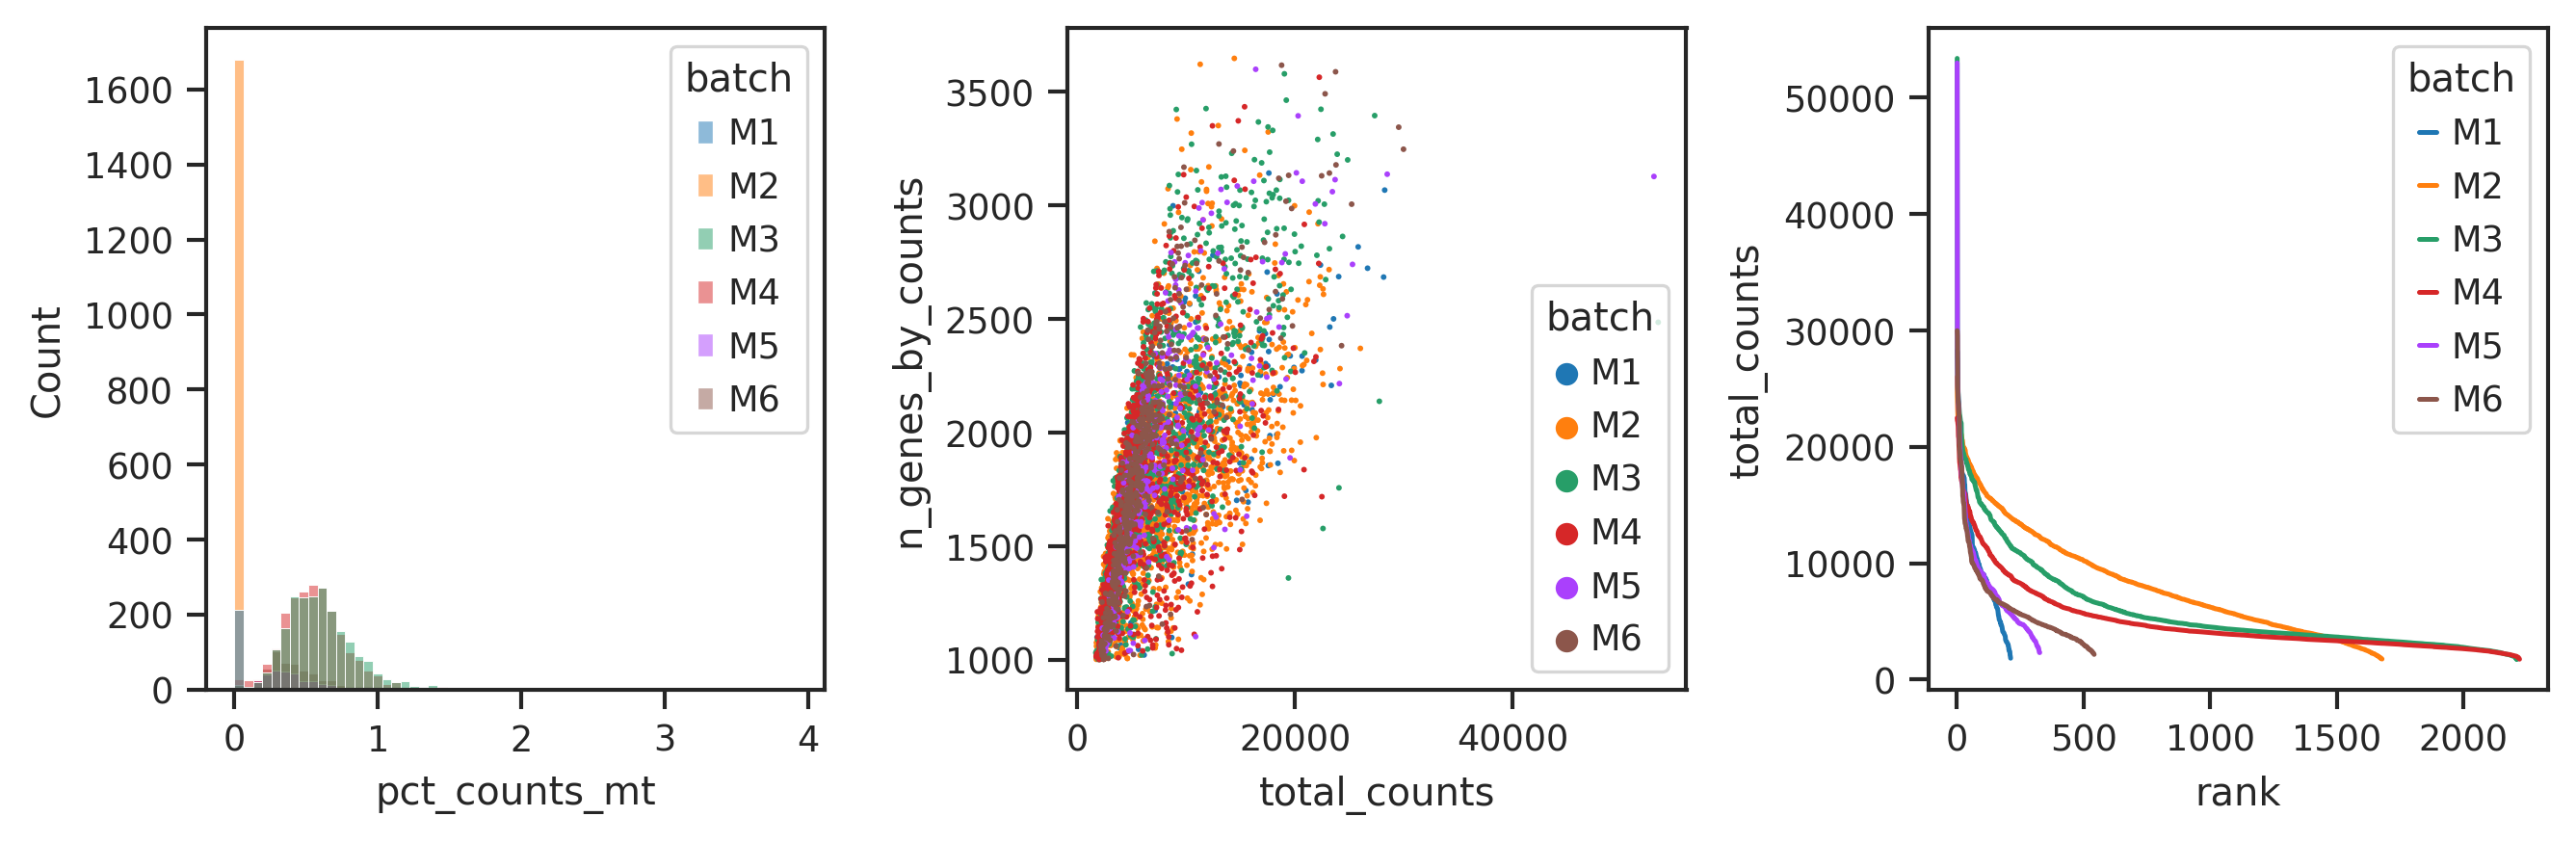

In [14]:
qc_plot(adata, show_thresh=False)

# Create pseudobulk signatures

In [15]:
def create_signature_matrix(adata, obs_key, save_path):
    signatures = pd.DataFrame(index=adata.var_names)
    for cell_type in adata.obs[obs_key].unique():
        signatures[cell_type] = adata[adata.obs[obs_key] == cell_type].X.mean(axis=0)
    signatures.to_csv(save_path)
    return signatures

## Full atlas

In [16]:
signatures = create_signature_matrix(adata, "cell_type", "/notebook/Joe/M-cells/analysis/cell_type_signatures/respiratory_epithelium_signatures.csv")

In [17]:
signatures

,Club,Basal,Ciliated,Tuft,Neuroendocrine,Goblet,Ionocyte
Xkr4,0.000000,0.001372,0.000000,0.009530,0.000000,0.007835,0.000000
Gm37381,0.000000,0.000000,0.014700,0.000000,0.000000,0.000000,0.000000
Rp1,0.000471,0.000404,0.076920,0.000000,0.000000,0.000000,0.000000
Mrpl15,0.238144,0.300105,0.220430,0.279630,0.194917,0.195450,0.115427
Lypla1,0.133026,0.313269,0.153082,0.096989,0.164905,0.128417,0.319291
...,...,...,...,...,...,...,...
AC168977.2,0.000726,0.000745,0.000000,0.000000,0.000000,0.000000,0.000000
AC168977.1,0.001509,0.002993,0.007302,0.000000,0.000000,0.000000,0.065024
PISD,0.037837,0.077928,0.459985,0.060441,0.217127,0.033620,0.113355
DHRSX,0.107564,0.273345,0.251567,0.138733,0.204021,0.450491,0.358566


In [18]:
signatures.columns = signatures.columns + "_respiratory"
signatures

,Club_respiratory,Basal_respiratory,Ciliated_respiratory,Tuft_respiratory,Neuroendocrine_respiratory,Goblet_respiratory,Ionocyte_respiratory
Xkr4,0.000000,0.001372,0.000000,0.009530,0.000000,0.007835,0.000000
Gm37381,0.000000,0.000000,0.014700,0.000000,0.000000,0.000000,0.000000
Rp1,0.000471,0.000404,0.076920,0.000000,0.000000,0.000000,0.000000
Mrpl15,0.238144,0.300105,0.220430,0.279630,0.194917,0.195450,0.115427
Lypla1,0.133026,0.313269,0.153082,0.096989,0.164905,0.128417,0.319291
...,...,...,...,...,...,...,...
AC168977.2,0.000726,0.000745,0.000000,0.000000,0.000000,0.000000,0.000000
AC168977.1,0.001509,0.002993,0.007302,0.000000,0.000000,0.000000,0.065024
PISD,0.037837,0.077928,0.459985,0.060441,0.217127,0.033620,0.113355
DHRSX,0.107564,0.273345,0.251567,0.138733,0.204021,0.450491,0.358566


In [19]:
signatures.to_csv("/notebook/Joe/M-cells/analysis/cell_type_signatures/respiratory_epithelium_signatures.csv")